## Getting Started

### Task 1: Import Libraries

In [1]:
# Switch the working directory
%cd usercode
import numpy as np
import matplotlib.pyplot as plt
import os

/usercode


In [2]:
plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

### Task 2: Import the Image

The original image has length = 300 and width = 451.


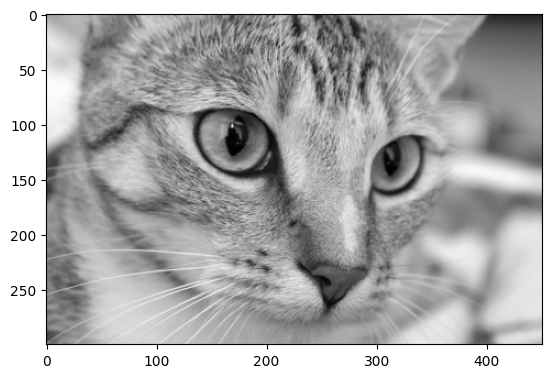

In [3]:
img = plt.imread('chelsea.pgm') 
(l, w) = img.shape
plt.imshow(img)
print(f'The original image has length = {l} and width = {w}.')

### Task 3: Pad the Image

The zero-padded image has length = 304 and width = 456


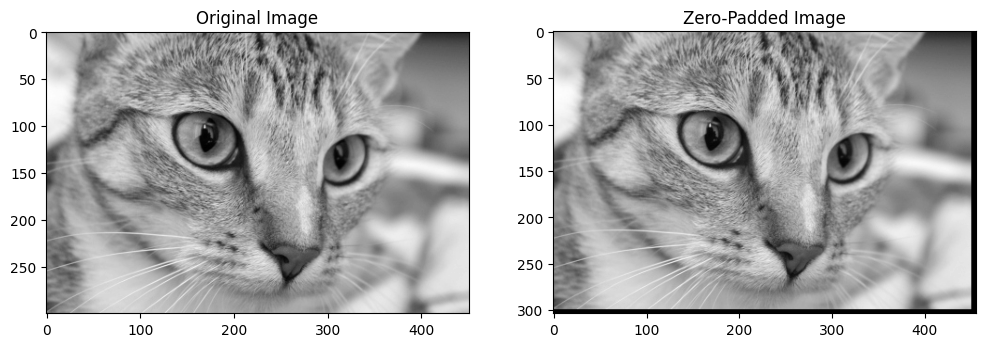

In [4]:
# Zero pad the image
window_size = 8
img_pad  = np.pad(img, pad_width=[(0, window_size - l%window_size),(0, window_size - w%window_size)], mode='constant')

# Store the dimensions of the zero-padded image.
(length, width) = img_pad.shape

# Display the original and zero-padded images alongside each other.
fig, ax = plt.subplots(1, 2, figsize = (12, 12))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(img_pad)
ax[1].set_title('Zero-Padded Image')

print(f'The zero-padded image has length = {length} and width = {width}')

## Create the Image Encoder

### Task 4: Implement the DCT Algorithm

In [6]:
def dct(img_block):
    '''
    img_block: The matrix of the image pixels
    returns: matrix of DCT coefficients in float dtype
    '''
    # Initializing the matrix of the transformed image
    img = img_block.astype('float')
    dct_img = np.zeros((8, 8))
    N = 8
    one_over_sqrt2 = 1.0/np.sqrt(2)
    pi_over_N = np.pi/N
    
    for k1 in range(N):
        for k2 in range(N):
            if k1 == 0 and k2 == 0:
                c = 1/2
            elif k1 == 0 or k2 == 0:
                c = one_over_sqrt2
            else:
                c = 1.0
                
            pi_k1 = pi_over_N * k1
            pi_k1_h = pi_k1 * 0.5

            pi_k2 = pi_over_N * k2
            pi_k2_h = pi_k2 * 0.5

            for n1 in range(N):
                for n2 in range(N):
                    dct_img[k1, k2] += (img[n1, n2]) * np.cos(pi_k1 * n1 + pi_k1_h) * np.cos(pi_k2 * n2 + pi_k2_h)
            dct_img[k1, k2] *= c
    return dct_img * 2/N

### Task 5: Visualize the Image Blocks

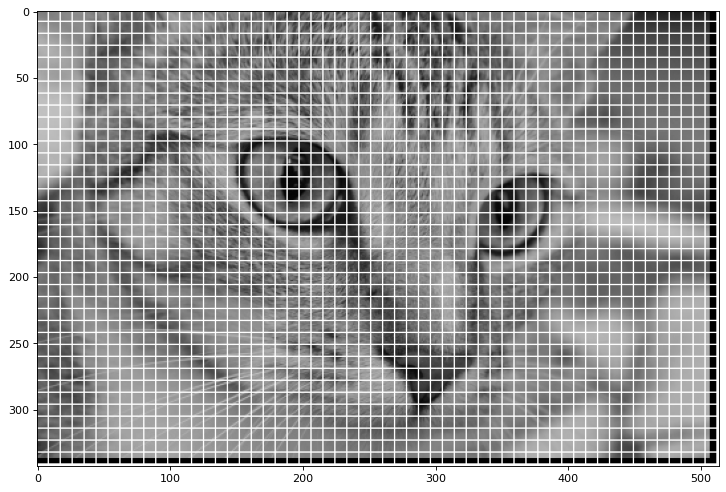

In [7]:
rows = length//window_size
cols = width//window_size
gap = 1
# Create the block image
display_img = np.ones((length+gap*(rows+1), width+gap*(cols+1)))*255
for i in range(0, length, window_size):
  for j in range(0, width, window_size):
    x = gap*(i//window_size)
    y = gap*(j//window_size)
    display_img[i+x:i+x+window_size, j+y:j+y+window_size] = \
    img_pad[i:i+window_size, j:j+window_size]
# Display the image blocks
plt.figure(figsize=(11, 10), dpi=80)
plt.imshow(display_img)

### Task 6: Apply DCT to the Image Blocks

In [8]:
img_dct = np.zeros((length, width))
for i in range(0, length, window_size):
    for j in range(0, width, window_size):
        img_dct[i:i+window_size, j:j+window_size] = dct(img_pad[i:i+window_size, j:j+window_size])

### Task 7: Quantize the Image Blocks

In [10]:
jpeg_table = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

In [11]:
for i in range(0, length, window_size):
    for j in range(0, width, window_size):
        img_dct[i:i+window_size, j:j+window_size] = np.round(img_dct[i:i+window_size, j:j+window_size] / jpeg_table)

### Task 8: Scan and Encode the Image Data

In [12]:
# This array depicts the zigzag reading of matrix elements. 
# You can use it in the subsequent tasks for zigzag matrix traversal.

zigzag = np.array([[ 0,  1,  5,  6, 14, 15, 27, 28],
                  [ 2,  4,  7, 13, 16, 26, 29, 42],
                  [ 3,  8, 12, 17, 25, 30, 41, 43],
                  [ 9, 11, 18, 24, 31, 40, 44, 53],
                  [10, 19, 23, 32, 39, 45, 52, 54],
                  [20, 22, 33, 38, 46, 51, 55, 60],
                  [21, 34, 37, 47, 50, 56, 59, 61],
                  [35, 36, 48, 49, 57, 58, 62, 63]]).astype('int')

In [13]:
img_dct += 127
# Declare a 1D array to keep values after zigzag scanning
img_zigzag = np.zeros(length*width).astype('uint8')
quality = 32 # This value ranges from 1 to 64. In this example, we're setting it as 32. This value can be changed. 
bn = 0
for i in range(0, length, window_size):
    for j in range(0, width, window_size):
        for k in range(window_size):
            for m in range(window_size):
                img_zigzag[bn*quality+zigzag[k][m]] = img_dct[i+k][j+m]
        bn += 1

### Task 9: Store Image Data to a File

In [14]:
# Write the encoded image to the file
sz = ((length//window_size)*(width//window_size))*quality
with open("chelsea.enc", 'wb') as f:
    np.array([l, w, quality]).astype('int64').tofile(f)
    img_zigzag[0:sz].tofile(f)

## Create the Image Decoder

### Task 10: Read the Image Data from the File

In [15]:
# Read the image dimensions
window_size = 8
with open("chelsea.enc",'rb') as f:
    (l_dec, w_dec, quality_dec) = np.fromfile(f,dtype = np.int64, count = 3, sep = "")

# Calculate image dimensions after zero padding
img_data = np.zeros((l_dec,w_dec))
img_data_pad  = np.pad(img_data, pad_width=[(0, window_size - l_dec%window_size),(0, window_size - w_dec%window_size)], mode='constant')
(length_dec, width_dec) = img_data_pad.shape

# Read image data
with open("chelsea.enc",'rb') as f:
    dec_full = np.fromfile(f, dtype='uint8', offset=24, count=-1, sep="").astype('int64')

### Task 11: Decode the Image Data

In [16]:
dec_full -= 127

# Zigzag scanning for conversion in 2D
bn = 0
for i in range(0, length_dec, window_size):
    for j in range(0, width_dec, window_size):
        for k in range(window_size):
            for m in range(window_size):
                if zigzag[k][m] < quality_dec:  
                    img_data_pad[i+k][j+m] = dec_full[bn*quality_dec+zigzag[k][m]]
        bn += 1

# Inverse quantization
for i in range(0, length_dec, window_size):
    for j in range(0, width_dec, window_size):
        img_data_pad[i:i+window_size, j:j+window_size] = img_data_pad[i:i+window_size, j:j+window_size] * jpeg_table

### Task 12: Implement the Inverse DCT Function

In [17]:
def idct(img_block):
    '''
    Input is block of 8x8
    Output is idct of 8x8 block 
    Output dtype is float64
    '''
    N = 8
    idct_block = np.zeros((N,N))
    block = img_block.astype('float')
    pi_over_N = np.pi/N
    one_over_sqrt2 = 1.0/np.sqrt(2) 
    for k1 in range(N):
        for k2 in range(N):
            for n1 in range(N):
                for n2 in range(N):
                    if n1 == 0 and n2 == 0:
                        c = 0.5
                    elif n1 == 0 or n2 == 0:
                        c = one_over_sqrt2
                    else:
                        c = 1.0
                    idct_block[k1, k2] += block[n1, n2] * c * np.cos(pi_over_N * (k1 + 0.5) * n1) * np.cos(pi_over_N * (k2 + 0.5) * n2)       
    return idct_block * 2/N

### Task 13: Apply Inverse DCT of the Image Blocks

In [18]:
# Apply the IDCT to blocks of data
img_idct = np.zeros((length_dec, width_dec))
for i in range(0,   length_dec, window_size):
    for j in range(0, width_dec, window_size):
        img_idct[i:i+window_size, j:j+window_size] =  idct(img_data_pad[i:i+window_size, j:j+window_size])

In [19]:
# Clip to range
np.putmask(img_idct, img_idct > 255, 255)
np.putmask(img_idct, img_idct < 0, 0)

### Task 14: Obtain and Display the Final Image

In [20]:
img_idct = img_idct[0:l_dec, 0:w_dec]

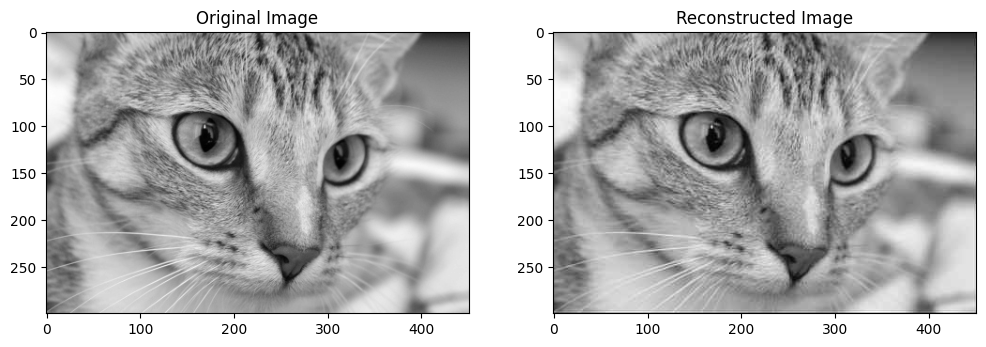

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (12, 12))

ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(img_idct)
ax[1].set_title('Reconstructed Image')

plt.show()

## Modulerization and Quality Comparison

### Task 15: Modulerize the Encoding Algorithm

In [22]:
def encode(img_file, quality_level):
    encoded_file_name = 'img_' + str(quality_level) + '.enc'
    # Read image file
    img = plt.imread(img_file) 
    (l, w) = img.shape

    # Perform zero padding if required
    window_size = 8
    img_pad  = np.pad(img, pad_width=[(0, window_size - l%window_size),(0, window_size - w%window_size)], mode='constant')

    # Adjust length and width according to the padded image
    (length, width) = img_pad.shape
    # Apply the DCT on image blocks
    img_dct = np.zeros((length, width))
    for i in range(0, length, window_size):
        for j in range(0, width, window_size):
            img_dct[i:i+window_size, j:j+window_size] = dct(img_pad[i:i+window_size, j:j+window_size])
    # Quantization
    jpeg_table = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])
    for i in range(0, length, window_size):
        for j in range(0, width, window_size):
            img_dct[i:i+window_size, j:j+window_size] = np.round(img_dct[i:i+window_size, j:j+window_size] / jpeg_table)
    img_dct += 127 # Shift range from 0 to 255
    # Prepare image zigzag scan
    img_zigzag = np.zeros(length*width).astype('uint8')
    quality = quality_level # Range 1–64, where 64 is the best quality
    zigzag = np.array([[ 0,  1,  5,  6, 14, 15, 27, 28],
                    [ 2,  4,  7, 13, 16, 26, 29, 42],
                    [ 3,  8, 12, 17, 25, 30, 41, 43],
                    [ 9, 11, 18, 24, 31, 40, 44, 53],
                    [10, 19, 23, 32, 39, 45, 52, 54],
                    [20, 22, 33, 38, 46, 51, 55, 60],
                    [21, 34, 37, 47, 50, 56, 59, 61],
                    [35, 36, 48, 49, 57, 58, 62, 63]]).astype('int')
    bn = 0
    for i in range(0, length, window_size):
        for j in range(0, width, window_size):
            for k in range(window_size):
                for m in range(window_size):
                    img_zigzag[bn*quality+zigzag[k][m]] = img_dct[i+k][j+m]
            bn += 1
  
    # Write decoded image to the file
    sz = ((length//window_size)*(width//window_size))*quality # ((length*width)//64)*quality
    with open(encoded_file_name, 'wb') as f:
        np.array([l, w, quality]).astype('int64').tofile(f)
        img_zigzag[0:sz].tofile(f)

    return encoded_file_name

### Task 16: Modulerize the Decoding Algorithm

In [23]:
def decode(img_file):
    # Read image dimensions
    window_size = 8
    with open(img_file,'rb') as f:
        (l_dec, w_dec, quality_dec) = np.fromfile(f,dtype='int64', count = 3, sep = "")
    # Calculate image dimensions after zero padding
    img_data = np.zeros((l_dec,w_dec))
    img_data_pad  = np.pad(img_data, pad_width=[(0, window_size - l_dec%window_size),(0, window_size - w_dec%window_size)], mode='constant')
    (length_dec, width_dec) = img_data_pad.shape
    # Read image data
    with open(img_file,'rb') as f:
        dec_full = np.fromfile(f, dtype='uint8', offset=24, count=-1, sep="").astype('int64')
    dec_full -= 127
    # Zagzig scanning for conversion in 2D
    zagzig = np.array([[ 0,  1,  5,  6, 14, 15, 27, 28],
                      [ 2,  4,  7, 13, 16, 26, 29, 42],
                      [ 3,  8, 12, 17, 25, 30, 41, 43],
                      [ 9, 11, 18, 24, 31, 40, 44, 53],
                      [10, 19, 23, 32, 39, 45, 52, 54],
                      [20, 22, 33, 38, 46, 51, 55, 60],
                      [21, 34, 37, 47, 50, 56, 59, 61],
                      [35, 36, 48, 49, 57, 58, 62, 63]]).astype('int')
    bn = 0
    for i in range(0, length_dec, window_size):
        for j in range(0, width_dec, window_size):
            for k in range(window_size):
                for m in range(window_size):
                    if zagzig[k][m] < quality_dec:
                        img_data_pad[i+k][j+m] = dec_full[bn*quality_dec+zagzig[k][m]]
            bn += 1
    # Inverse quantization
    jpeg_table = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  
                  [12, 12, 14, 19, 26, 48, 60, 55],
                  [14, 13, 16, 24, 40, 57, 69, 56],
                  [14, 17, 22, 29, 51, 87, 80, 62],
                  [18, 22, 37, 56, 68, 109, 103, 77],
                  [24, 35, 55, 64, 81, 104, 113, 92],
                  [49, 64, 78, 87, 103, 121, 120, 101],
                  [72, 92, 95, 98, 112, 100, 103, 99]])
    for i in range(0, length_dec, window_size):
        for j in range(0, width_dec, window_size):
            img_data_pad[i:i+window_size, j:j+window_size] = img_data_pad[i:i+window_size, j:j+window_size] * jpeg_table
    # Apply idct to blocks of data
    img_idct = np.zeros((length_dec, width_dec))
    for i in range(0, length_dec, window_size):
        for j in range(0, width_dec, window_size):
            img_idct[i:i+window_size, j:j+window_size] =  idct(img_data_pad[i:i+window_size, j:j+window_size])
    img_decoded = img_idct[0:l_dec, 0:w_dec]
    # Clip to range
    np.putmask(img_decoded, img_decoded > 255, 255)
    np.putmask(img_decoded, img_decoded < 0, 0)

    return img_decoded

### Task 17: Test the Encoding and Decoding Modules

In [24]:
img_64 = decode(encode('chelsea.pgm', 64))
img_50 = decode(encode('chelsea.pgm', 50))
img_32 = decode(encode('chelsea.pgm', 32))
img_24 = decode(encode('chelsea.pgm', 24))
img_12 = decode(encode('chelsea.pgm', 12))
img_3 = decode(encode('chelsea.pgm', 3))

### Task 18: Compute the Compression Ratio of the Compressed Images

In [28]:
def get_filesize(filename):
    return os.stat(filename).st_size

In [29]:
size_original = get_filesize('chelsea.pgm')
size_64 = get_filesize('img_64.enc')
size_50 = get_filesize('img_50.enc')
size_32 = get_filesize('img_32.enc')
size_24 = get_filesize('img_24.enc')
size_12 = get_filesize('img_12.enc')
size_3 = get_filesize('img_3.enc')

In [31]:
cr_64 = size_original / size_64
cr_50 = size_original / size_50
cr_32 = size_original / size_32
cr_24 = size_original / size_24
cr_12 = size_original / size_12
cr_3  = size_original / size_3  

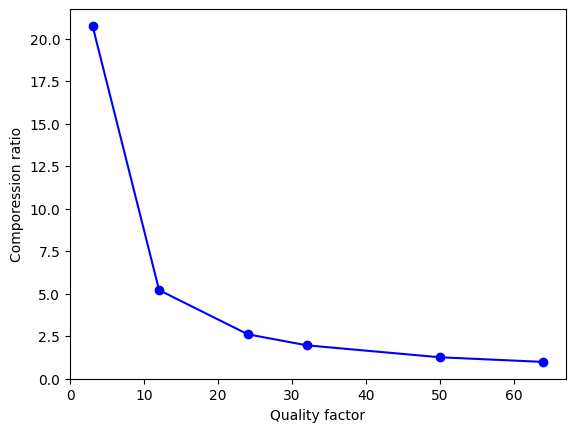

In [32]:
quality_arr = [64, 50, 32, 24, 12, 3]
cr_arr = [cr_64, cr_50, cr_32, cr_24, cr_12, cr_3]

fig, ax = plt.subplots()
ax.plot(quality_arr, cr_arr, 'bo-')
ax.set_xlabel('Quality factor')
ax.set_ylabel('Comporession ratio')

plt.show()

### Task 19: Plot the Compressed Images

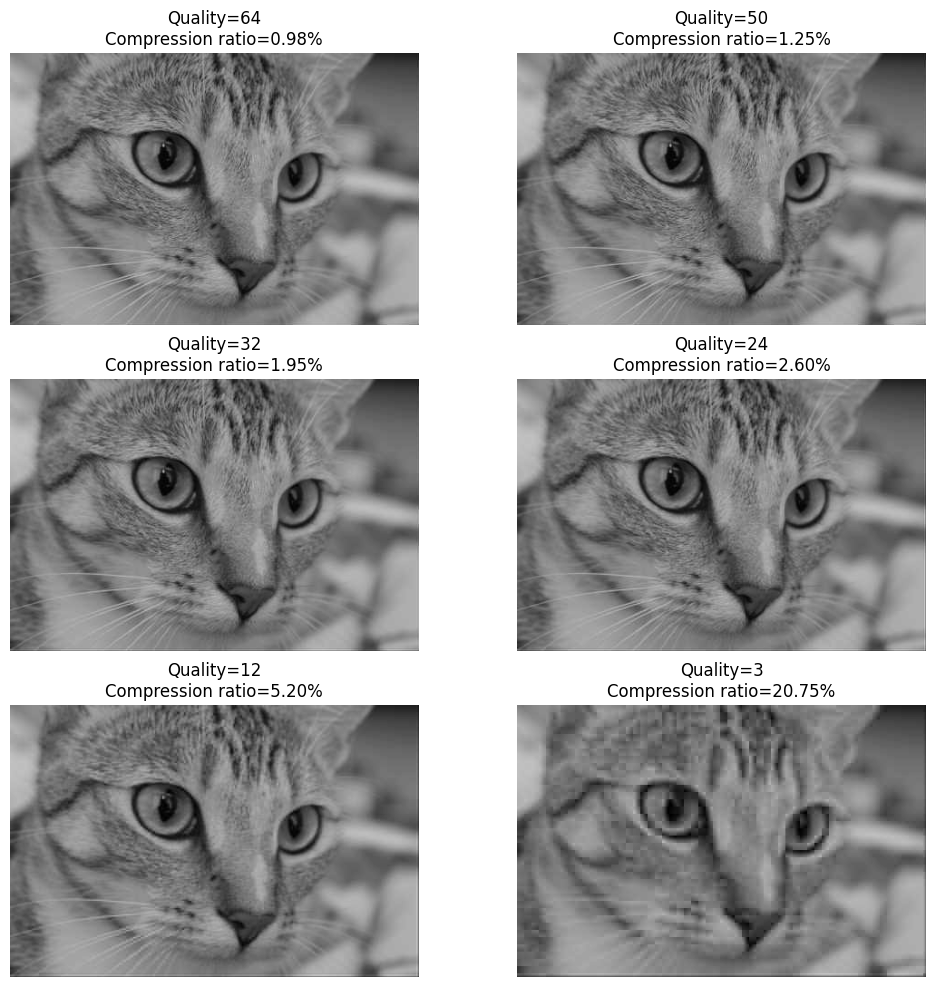

In [33]:
fig, ax = plt.subplots(3, 2, figsize = (12, 12))
ax[0, 0].imshow(img_64, vmin = 0, vmax = 255)
ax[0, 0].set_title('Quality=64\nCompression ratio={:0.2f}%'.format(cr_64))
ax[0, 1].imshow(img_50, vmin = 0, vmax = 255)
ax[0, 1].set_title('Quality=50\nCompression ratio={:0.2f}%'.format(cr_50))
ax[1, 0].imshow(img_32, vmin = 0, vmax = 255)
ax[1, 0].set_title('Quality=32\nCompression ratio={:0.2f}%'.format(cr_32))
ax[1, 1].imshow(img_24, vmin = 0, vmax = 255)
ax[1, 1].set_title('Quality=24\nCompression ratio={:0.2f}%'.format(cr_24))
ax[2, 0].imshow(img_12, vmin = 0, vmax = 255)
ax[2, 0].set_title('Quality=12\nCompression ratio={:0.2f}%'.format(cr_12))
ax[2, 1].imshow(img_3, vmin = 0, vmax = 255)
ax[2, 1].set_title('Quality=3\nCompression ratio={:0.2f}%'.format(cr_3))
[axi.set_axis_off() for axi in ax.ravel()]

plt.show()